In [1]:
import pandas as pd

luco_df = pd.read_csv(r"/workspaces/Series_temporales_2_Rene/src/Aquifer_Luco.csv")
print("Dimensiones:", luco_df.shape)
display(pd.DataFrame(luco_df.columns, columns=['Columnas']))

Dimensiones: (7487, 22)


Columnas
0                                  Date
1                    Rainfall_Simignano
2        Rainfall_Siena_Poggio_al_Vento
3                      Rainfall_Mensano
4                Rainfall_Montalcinello
5         Rainfall_Monticiano_la_Pineta
6                    Rainfall_Sovicille
7                  Rainfall_Ponte_Orgia
8                    Rainfall_Scorgiano
9                    Rainfall_Pentolina
10       Rainfall_Monteroni_Arbia_Biena
11  Depth_to_Groundwater_Podere_Casetta
12         Depth_to_Groundwater_Pozzo_1
13         Depth_to_Groundwater_Pozzo_3
14         Depth_to_Groundwater_Pozzo_4
15    Temperature_Siena_Poggio_al_Vento
16                  Temperature_Mensano
17                Temperature_Pentolina
18    Temperature_Monteroni_Arbia_Biena
19                       Volume_Pozzo_1
20                       Volume_Pozzo_3
21                       Volume_Pozzo_4

In [2]:

# Conversi√≥n correcta de la columna 'Date'
luco_df['Date'] = pd.to_datetime(luco_df['Date'], dayfirst=True, errors='coerce')
luco_df = luco_df.sort_values('Date').set_index('Date')

# Verificar duplicados en el √≠ndice (fechas)
duplicados = luco_df.index.duplicated().sum()
print(f"N√∫mero de fechas duplicadas: {duplicados}")

# An√°lisis de valores nulos por columna
missing = luco_df.isnull().sum()
missing_percent = (missing / len(luco_df)) * 100
missing_summary = pd.DataFrame({
    'Valores nulos': missing,
    '% del total': missing_percent.round(2)
}).sort_values(by='Valores nulos', ascending=False)

display(missing_summary)


N√∫mero de fechas duplicadas: 0


Valores nulos  % del total
Depth_to_Groundwater_Pozzo_3                  6567        87.71
Rainfall_Siena_Poggio_al_Vento                6536        87.30
Depth_to_Groundwater_Pozzo_4                  6518        87.06
Depth_to_Groundwater_Pozzo_1                  6475        86.48
Rainfall_Ponte_Orgia                          6227        83.17
Rainfall_Mensano                              5765        77.00
Volume_Pozzo_1                                5479        73.18
Volume_Pozzo_4                                5479        73.18
Volume_Pozzo_3                                5479        73.18
Rainfall_Pentolina                            5371        71.74
Rainfall_Monticiano_la_Pineta                 5282        70.55
Rainfall_Scorgiano                            4451        59.45
Rainfall_Monteroni_Arbia_Biena                4383        58.54
Depth_to_Groundwater_Podere_Casetta           4141        55.31
Rainfall_Montalcinello                         962        12.85
Rainfall_Sovicille                             830        11.09
Rainfall_Simignano                             665         8.88
Temperature_Pentolina                            0         0.00
Temperature_Mensano                              0         0.00
Temperature_Siena_Poggio_al_Vento                0         0.00
Temperature_Monteroni_Arbia_Biena                0         0.00

##Paso 3: Imputaci√≥n de valores faltantes

Aplicamos diferentes estrategias de imputaci√≥n, adaptadas al tipo de variable:

- **Profundidad del nivel fre√°tico (`Depth_to_Groundwater_`)**:  
  Se utiliza interpolaci√≥n temporal (`interpolate(method='time')`) para mantener la continuidad de la serie.

- **Volumen extra√≠do (`Volume_`)**:  
  Tambi√©n se imputa por interpolaci√≥n temporal, ya que representa cantidades acumuladas de forma continua.

- **Precipitaciones (`Rainfall_`)**:  
  Se imputan mediante `forward fill` seguido de `backward fill`, √∫til para eventos meteorol√≥gicos persistentes.

- **Temperaturas (`Temperature_`)**:  
  No presentan valores nulos, por lo tanto no se modifica su contenido.


In [3]:
# Clasificar columnas seg√∫n tipo
depth_cols = [col for col in luco_df.columns if 'Depth_to_Groundwater' in col]
volume_cols = [col for col in luco_df.columns if 'Volume' in col]
rainfall_cols = [col for col in luco_df.columns if 'Rainfall' in col]

# Imputaci√≥n por interpolaci√≥n para columnas continuas
luco_df[depth_cols] = luco_df[depth_cols].interpolate(method='time')
luco_df[volume_cols] = luco_df[volume_cols].interpolate(method='time')

# Imputaci√≥n por forward-fill y backward-fill para precipitaciones
luco_df[rainfall_cols] = luco_df[rainfall_cols].fillna(method='ffill').fillna(method='bfill')

# Validaci√≥n final: mostrar columnas a√∫n con nulos
luco_df.isnull().sum().sort_values(ascending=False)


/tmp/ipykernel_4938/191948837.py:11: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  luco_df[rainfall_cols] = luco_df[rainfall_cols].fillna(method='ffill').fillna(method='bfill')


Depth_to_Groundwater_Pozzo_1           6453
Depth_to_Groundwater_Pozzo_3           6453
Depth_to_Groundwater_Pozzo_4           6453
Volume_Pozzo_4                         5479
Volume_Pozzo_1                         5479
Volume_Pozzo_3                         5479
Depth_to_Groundwater_Podere_Casetta    2973
Rainfall_Monticiano_la_Pineta             0
Rainfall_Siena_Poggio_al_Vento            0
Rainfall_Simignano                        0
Rainfall_Montalcinello                    0
Rainfall_Mensano                          0
Rainfall_Sovicille                        0
Rainfall_Monteroni_Arbia_Biena            0
Rainfall_Ponte_Orgia                      0
Rainfall_Scorgiano                        0
Rainfall_Pentolina                        0
Temperature_Pentolina                     0
Temperature_Mensano                       0
Temperature_Siena_Poggio_al_Vento         0
Temperature_Monteroni_Arbia_Biena         0
dtype: int64

In [4]:
# Completar valores extremos que no fueron cubiertos por la interpolaci√≥n
luco_df[depth_cols] = luco_df[depth_cols].bfill().ffill()
luco_df[volume_cols] = luco_df[volume_cols].bfill().ffill()

# Revisi√≥n final de nulos
luco_df.isnull().sum().sort_values(ascending=False)


Rainfall_Simignano                     0
Rainfall_Siena_Poggio_al_Vento         0
Rainfall_Mensano                       0
Rainfall_Montalcinello                 0
Rainfall_Monticiano_la_Pineta          0
Rainfall_Sovicille                     0
Rainfall_Ponte_Orgia                   0
Rainfall_Scorgiano                     0
Rainfall_Pentolina                     0
Rainfall_Monteroni_Arbia_Biena         0
Depth_to_Groundwater_Podere_Casetta    0
Depth_to_Groundwater_Pozzo_1           0
Depth_to_Groundwater_Pozzo_3           0
Depth_to_Groundwater_Pozzo_4           0
Temperature_Siena_Poggio_al_Vento      0
Temperature_Mensano                    0
Temperature_Pentolina                  0
Temperature_Monteroni_Arbia_Biena      0
Volume_Pozzo_1                         0
Volume_Pozzo_3                         0
Volume_Pozzo_4                         0
dtype: int64

Paso 4: Exploraci√≥n visual de la variable objetivo

Ver c√≥mo se comporta la serie temporal de:

##Paso 4: Exploraci√≥n visual de la variable objetivo

En este paso visualizamos la evoluci√≥n de la variable objetivo:
**`Depth_to_Groundwater_Podere_Casetta`**

Esta observaci√≥n nos permitir√°:
- Detectar la existencia de una tendencia general (ascendente, descendente, estable).
- Evaluar visualmente la estacionalidad.
- Identificar anomal√≠as o cortes abruptos.
- Decidir qu√© tipo de modelo puede ajustarse mejor (lineal, autoregresivo, no param√©trico).


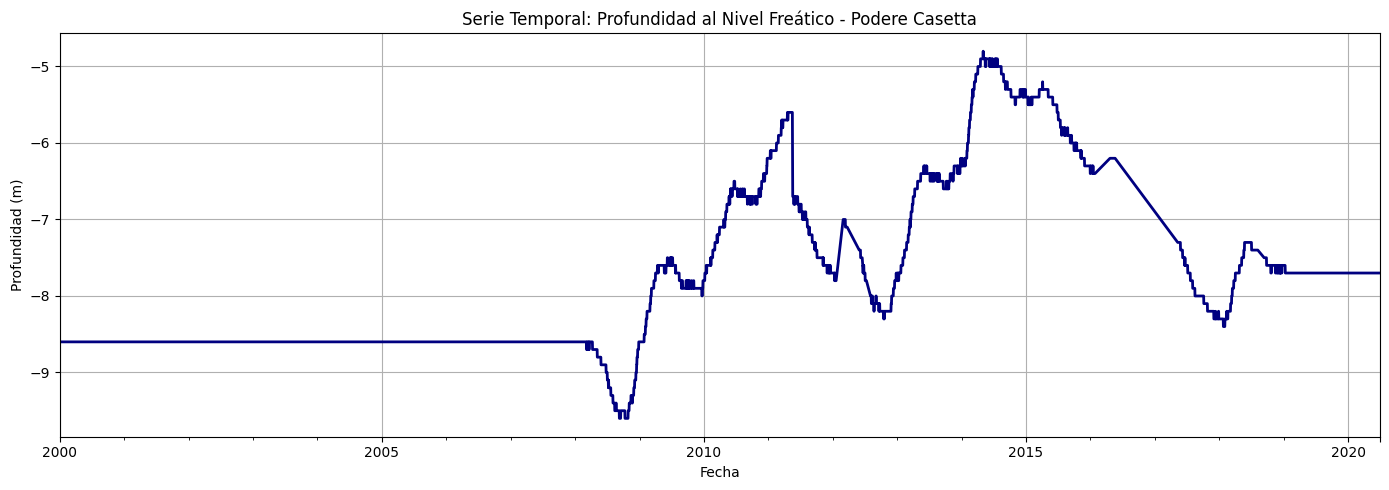

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))
luco_df['Depth_to_Groundwater_Podere_Casetta'].plot(color='navy', linewidth=2)
plt.title('Serie Temporal: Profundidad al Nivel Fre√°tico - Podere Casetta')
plt.ylabel('Profundidad (m)')
plt.xlabel('Fecha')
plt.grid(True)
plt.tight_layout()
plt.show()


## An√°lisis visual de la serie objetivo: `Depth_to_Groundwater_Podere_Casetta`

### Observaciones clave:

1. **Bloque plano (~2001‚Äì2008)**  
   - Existe una secci√≥n prolongada con valores constantes en torno a -8.7 m.
   - Esto puede indicar datos imputados, una frecuencia baja de medici√≥n, o incluso un sensor sin actividad.
   - Puede ser conveniente **excluir este tramo** al entrenar modelos, ya que no aporta variabilidad.

2. **2008 en adelante**  
   - Comienza una secuencia m√°s realista, con **fluctuaciones notorias en la profundidad**.
   - Se observa una **tendencia ascendente clara entre 2010 y 2014**, seguida de un descenso y estabilizaci√≥n.
   - Este patr√≥n es **caracter√≠stico de un acu√≠fero afectado por lluvias, temperatura y extracci√≥n**.

3. **√öltimos a√±os (~2018‚Äì2020)**  
   - La serie parece estabilizarse nuevamente.
   - Esto podr√≠a indicar el fin de un ciclo multianual o la entrada a un nuevo r√©gimen hidrol√≥gico.

---

###Implicaciones para el modelado:

- Es recomendable **recortar la serie a partir de ~2008** si se confirma que el bloque inicial fue imputado.
- La serie no es puramente lineal, por lo que podr√≠an funcionar bien modelos como:
  - **ARIMA con diferenciaci√≥n**
  - **Random Forest / XGBoost**
  - **Modelos basados en lags + clima**

- Tambi√©n es relevante estudiar la **autocorrelaci√≥n (ACF/PACF)** y la posible **estacionalidad** antes de definir el enfoque de predicci√≥n.


## Recorte temporal del dataset (post-2008)

Con base en el an√°lisis visual realizado, se detect√≥ que los datos anteriores a 2008 presentan un comportamiento plano, probablemente imputado o no representativo de la din√°mica real del acu√≠fero.

Por este motivo, se recorta el dataset para conservar √∫nicamente las observaciones a partir del **1 de enero de 2008**, fecha en la que comienzan a aparecer fluctuaciones reales en la serie temporal.

Este recorte permitir√°:

- Evitar sesgos al entrenar modelos predictivos.
- Reducir ruido y redundancia en los datos.
- Mejorar la detecci√≥n de patrones reales de comportamiento.


In [6]:
# Recortar el dataset a partir del 1 de enero de 2008
luco_df = luco_df[luco_df.index >= '2008-01-01']

print(f"Nuevo rango de fechas: {luco_df.index.min().date()} ‚Üí {luco_df.index.max().date()}")
print("Dimensiones despu√©s del recorte:", luco_df.shape)


Nuevo rango de fechas: 2008-01-01 ‚Üí 2020-06-30
Dimensiones despu√©s del recorte: (4565, 21)


##Paso 5: An√°lisis de autocorrelaci√≥n y estacionalidad

Antes de entrenar modelos, es esencial analizar si la serie temporal de `Depth_to_Groundwater_Podere_Casetta` presenta:

- **Autocorrelaci√≥n significativa**: Dependencia entre los valores actuales y pasados (lags).
- **Estacionalidad**: Repetici√≥n de patrones en intervalos regulares.

Utilizaremos:

- **ACF (Autocorrelation Function)**: Mide la correlaci√≥n de la serie con sus propios rezagos (lags).
- **PACF (Partial Autocorrelation Function)**: Mide la correlaci√≥n entre la serie y sus lags, eliminando la influencia de lags intermedios.

Estos gr√°ficos son clave para elegir:
- El orden (p, d, q) en modelos ARIMA/SARIMA.
- Cu√°ntos lags pueden ser √∫tiles como features en modelos supervisados (XGBoost, RF, etc.).


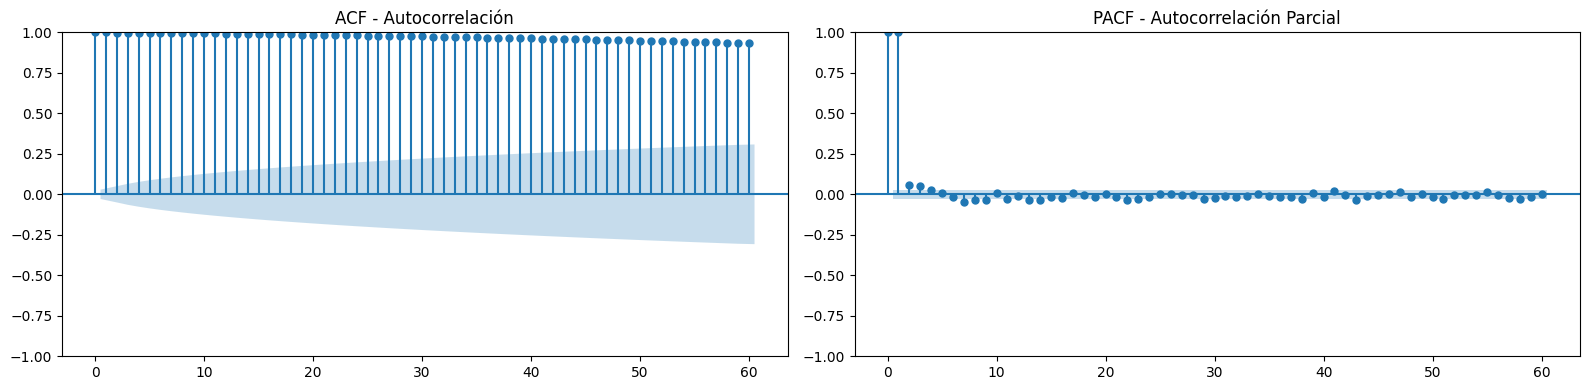

In [7]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# Seleccionar la serie objetivo ya limpia
serie = luco_df['Depth_to_Groundwater_Podere_Casetta']

# Crear gr√°ficos ACF y PACF
fig, axes = plt.subplots(1, 2, figsize=(16, 4))

plot_acf(serie, lags=60, ax=axes[0])
axes[0].set_title('ACF - Autocorrelaci√≥n')

plot_pacf(serie, lags=60, ax=axes[1], method='ywm')
axes[1].set_title('PACF - Autocorrelaci√≥n Parcial')

plt.tight_layout()
plt.show()


## An√°lisis de ACF y PACF

Tras visualizar la funci√≥n de autocorrelaci√≥n (ACF) y autocorrelaci√≥n parcial (PACF) de la serie `Depth_to_Groundwater_Podere_Casetta`, se obtienen las siguientes observaciones:

### ACF - Autocorrelaci√≥n
- La autocorrelaci√≥n se mantiene alta incluso en lags lejanos.
- El patr√≥n desciende lentamente, lo que sugiere una **serie no estacionaria**.

### PACF - Autocorrelaci√≥n Parcial
- El lag 1 muestra una autocorrelaci√≥n parcial muy alta.
- A partir del lag 2, las correlaciones caen r√°pidamente a casi cero.


## üìâ Prueba de Estacionariedad: Augmented Dickey-Fuller (ADF)

La prueba de Dickey-Fuller aumentada (ADF) se utiliza para evaluar si una serie temporal es **estacionaria**, es decir, si sus propiedades estad√≠sticas (media, varianza, autocorrelaci√≥n) se mantienen constantes en el tiempo.

- **Hip√≥tesis nula (H‚ÇÄ):** la serie NO es estacionaria (tiene ra√≠z unitaria).
- **Hip√≥tesis alternativa (H‚ÇÅ):** la serie es estacionaria.

### Interpretaci√≥n del resultado:
- Si el **p-valor > 0.05**, no se rechaza H‚ÇÄ ‚Üí la serie NO es estacionaria.
- Si el **p-valor < 0.05**, se rechaza H‚ÇÄ ‚Üí la serie es estacionaria.

Esta prueba nos ayudar√° a decidir si debemos diferenciar la serie (`d=1`) antes de aplicar modelos como ARIMA.


In [8]:
from statsmodels.tsa.stattools import adfuller

# Seleccionar la serie objetivo
serie = luco_df['Depth_to_Groundwater_Podere_Casetta']

# Ejecutar prueba ADF
adf_result = adfuller(serie)

# Mostrar resultados
print(f"ADF Statistic: {adf_result[0]:.4f}")
print(f"p-value: {adf_result[1]:.4f}")
print("\nValores cr√≠ticos:")
for key, value in adf_result[4].items():
    print(f"  {key}: {value:.4f}")


ADF Statistic: -1.8130
p-value: 0.3740

Valores cr√≠ticos:
  1%: -3.4318
  5%: -2.8622
  10%: -2.5671


 Interpretaci√≥n:

El p-value (0.3740) es mayor a 0.05, por lo tanto:

üëâ No podemos rechazar la hip√≥tesis nula (H‚ÇÄ).

‚û§ Conclusi√≥n:

La serie NO es estacionaria en su forma actual.

## Diferenciaci√≥n temporal (d=1) y reevaluaci√≥n de estacionariedad

Como la prueba ADF confirm√≥ que la serie original no es estacionaria, aplicamos una **diferenciaci√≥n temporal de orden 1**.

Esto implica transformar la serie `y(t)` a una nueva serie `y(t) - y(t-1)`, lo cual ayuda a eliminar tendencias acumulativas.

Luego de esto, volvemos a aplicar la prueba ADF para verificar si la serie ahora cumple con los requisitos de estacionariedad.

Adem√°s, graficamos la serie diferenciada para visualizar los cambios.


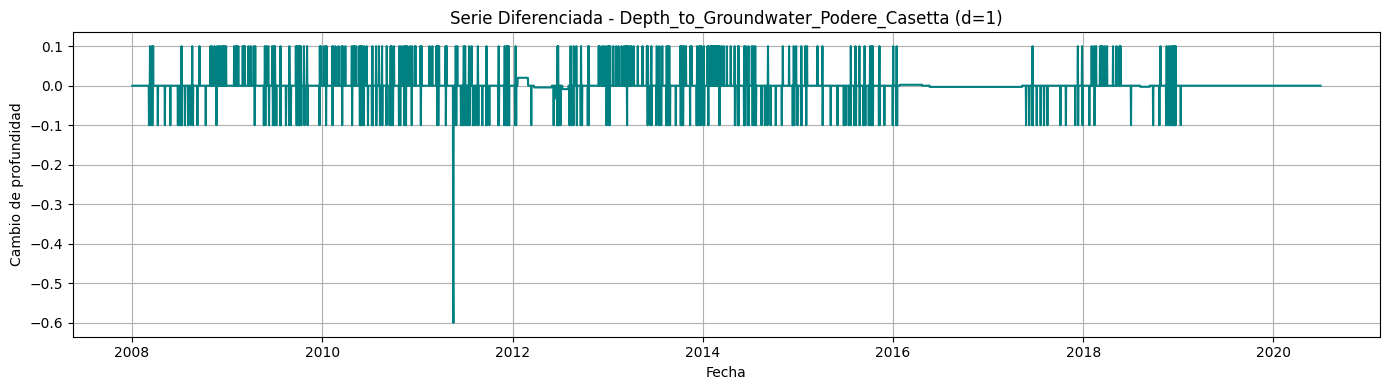

ADF Statistic (d=1): -9.8883
p-value: 0.0000

Valores cr√≠ticos:
  1%: -3.4318
  5%: -2.8622
  10%: -2.5671


In [9]:
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

# 1. Aplicar la diferenciaci√≥n temporal
serie_diff = serie.diff().dropna()

plt.figure(figsize=(14, 4))
plt.plot(serie_diff, color='teal')
plt.title('Serie Diferenciada - Depth_to_Groundwater_Podere_Casetta (d=1)')
plt.xlabel('Fecha')
plt.ylabel('Cambio de profundidad')
plt.grid(True)
plt.tight_layout()
plt.show()

# 3. Prueba ADF sobre la serie diferenciada
adf_result_diff = adfuller(serie_diff)

#Mostrar resultados
print(f"ADF Statistic (d=1): {adf_result_diff[0]:.4f}")
print(f"p-value: {adf_result_diff[1]:.4f}")
print("\nValores cr√≠ticos:")
for key, value in adf_result_diff[4].items():
    print(f"  {key}: {value:.4f}")


## Evaluaci√≥n de Estacionariedad tras Diferenciaci√≥n (d=1)

Luego de aplicar una diferenciaci√≥n de primer orden (`d=1`) a la serie `Depth_to_Groundwater_Podere_Casetta`, se ejecut√≥ nuevamente la prueba ADF para verificar si la serie ahora es estacionaria.

### Resultados de la prueba ADF:

- **ADF Statistic:** -9.8883
- **p-value:** 0.0000
- **Valores cr√≠ticos:**
  - 1%: -3.4318
  - 5%: -2.8622
  - 10%: -2.5671

### Interpretaci√≥n:

- El p-value < 0.05 indica que podemos rechazar la hip√≥tesis nula.
- Por lo tanto, **la serie diferenciada es estacionaria**.
- Se confirma que usar un modelo ARIMA con `d=1` es apropiado.

### Conclusi√≥n:

Con este resultado, estamos listos para:
- Ajustar un modelo **ARIMA(p=1, d=1, q=1)** como punto de partida.
- Comparar su rendimiento contra otras alternativas en pasos siguientes.


##Entrenamiento inicial del modelo ARIMA(1, 1, 1)

Con la serie ya transformada a estacionaria mediante diferenciaci√≥n (`d=1`), entrenamos un primer modelo ARIMA con par√°metros:

- **p = 1**: sugerido por el PACF
- **d = 1**: confirmado por la prueba ADF
- **q = 1**: captura ruido blanco residual (ACF con retardo)

Este modelo se ajustar√° a la serie original (`Depth_to_Groundwater_Podere_Casetta`) y nos permitir√° evaluar:

- Bondad de ajuste (AIC, BIC, HQIC)
- Diagn√≥stico de residuos
- Posibilidad de usarlo como baseline o refinarlo m√°s adelante


In [10]:
from statsmodels.tsa.arima.model import ARIMA

# Ajustar modelo ARIMA(1,1,1) sobre la serie original (no diferenciada)
modelo_arima = ARIMA(serie, order=(1, 1, 1))
resultado_arima = modelo_arima.fit()

# Mostrar resumen del modelo
resultado_arima.summary()

/workspaces/Series_temporales_2_Rene/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/workspaces/Series_temporales_2_Rene/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/workspaces/Series_temporales_2_Rene/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:     Depth_to_Groundwater_Podere_Casetta   No. Observations:                 4565
Model:                                  ARIMA(1, 1, 1)   Log Likelihood                9151.113
Date:                                 Tue, 06 May 2025   AIC                         -18296.227
Time:                                         23:05:49   BIC                         -18276.949
Sample:                                     01-01-2008   HQIC                        -18289.439
                                          - 06-30-2020                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3875      0.074      5.264      0.000       0.243       0.532
ma.L1         -0.4995      0.072     -6.908      0.000      -0.641      -0.358
sigma2         0.0011   6.34e-06    167.506      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.74   Jarque-Bera (JB):            535062.40
Prob(Q):                              0.39   Prob(JB):                         0.00
Heteroskedasticity (H):               0.19   Skew:                            -2.42
Prob(H) (two-sided):                  0.00   Kurtosis:                        55.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

##Predicci√≥n con ARIMA(1,1,1) y evaluaci√≥n contra valores reales

Separamos la serie temporal en dos partes:

- **Entrenamiento:** 80% de los datos (usados para entrenar el modelo)
- **Test:** 20% restantes (usados para evaluar la capacidad predictiva)

Entrenamos el modelo ARIMA(1,1,1) **solo con el set de entrenamiento**, y luego generamos predicciones para el per√≠odo de test.

Finalmente, graficamos los valores reales y predichos para comparar visualmente el rendimiento del modelo.


/workspaces/Series_temporales_2_Rene/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/workspaces/Series_temporales_2_Rene/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/workspaces/Series_temporales_2_Rene/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/workspaces/Series_temporales_2_Rene/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)

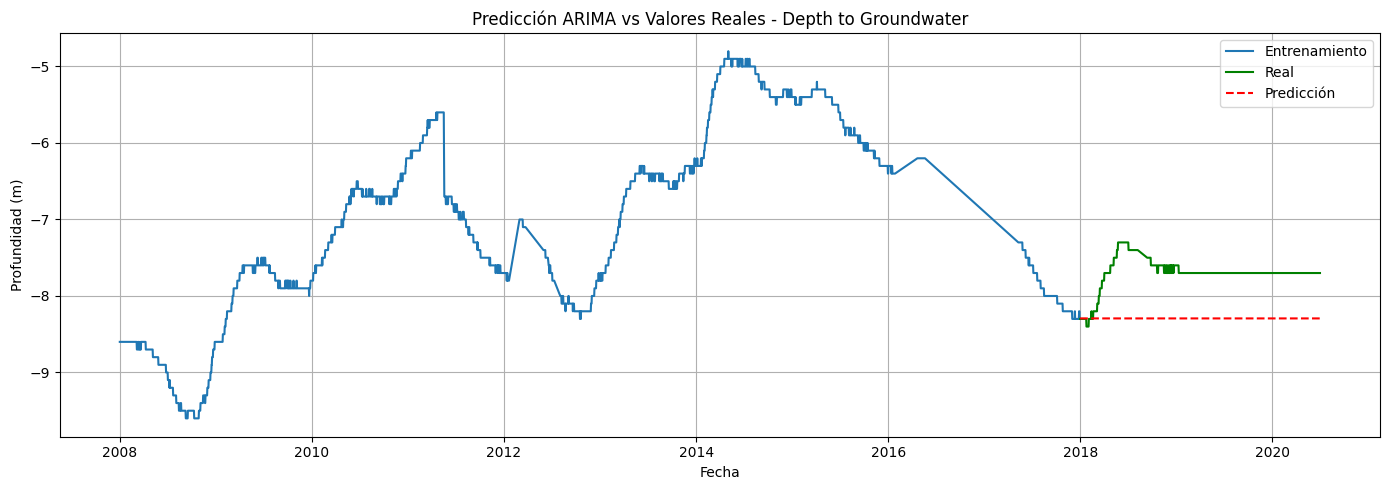

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 1. sseparar en entrenamiento (80%) y test (20%)
split_index = int(len(serie) * 0.8)
train, test = serie[:split_index], serie[split_index:]

# 2. Ajustar MOodelo ARIMA al set de entrenamiento
modelo_train = ARIMA(train, order=(1, 1, 1))
resultado_train = modelo_train.fit()

# 3. Predecir sobre el per√≠odo de test
start = test.index[0]
end = test.index[-1]
predicciones = resultado_train.predict(start=start, end=end, typ='levels')

# 4. Graficar valores reales vs predichos.
plt.figure(figsize=(14, 5))
plt.plot(train, label='Entrenamiento')
plt.plot(test, label='Real', color='green')
plt.plot(predicciones, label='Predicci√≥n', color='red', linestyle='--')
plt.title('Predicci√≥n ARIMA vs Valores Reales - Depth to Groundwater')
plt.xlabel('Fecha')
plt.ylabel('Profundidad (m)')
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()


##Evaluaci√≥n del rendimiento del modelo ARIMA

Para evaluar cuantitativamente la calidad de las predicciones del modelo ARIMA(1,1,1), se calculan las siguientes m√©tricas:

- **MAE (Mean Absolute Error)**: mide el error medio absoluto entre predicciones y valores reales.
- **RMSE (Root Mean Squared Error)**: mide la ra√≠z del error cuadr√°tico medio, penaliza m√°s los errores grandes.

Estas m√©tricas permitir√°n comparar con futuros modelos (XGBoost, etc.).


In [12]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Asegurar alineaci√≥n temporal
predicciones_alineadas = predicciones[:len(test)]

# Calcular m√©tricas
mae = mean_absolute_error(test, predicciones_alineadas)
rmse = np.sqrt(mean_squared_error(test, predicciones_alineadas))

print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")


MAE: 0.6041
RMSE: 0.6357


##Evaluaci√≥n del Modelo ARIMA(1,1,1)

Tras entrenar y predecir con el modelo ARIMA(1,1,1), se calcularon las siguientes m√©tricas de error sobre el conjunto de test:

- **MAE (Mean Absolute Error):** 0.6041
- **RMSE (Root Mean Squared Error):** 0.6357

###An√°lisis

- Estos valores indican un error medio moderado, razonable para un modelo baseline.
- Sin embargo, la predicci√≥n del modelo result√≥ **demasiado plana**, sin captar las variaciones reales presentes en la serie de test.

### Pr√≥ximo paso

Se propone construir un modelo de aprendizaje supervisado multivariable (como **XGBoost** o **Random Forest**) incorporando:

- Variables clim√°ticas (`Rainfall_*`, `Temperature_*`)
- Vol√∫menes de extracci√≥n (`Volume_*`)
- Lags temporales del target (`Depth_to_Groundwater_Podere_Casetta(t-1, t-2, ...)`)

Esto permitir√° capturar relaciones no lineales y complejas entre m√∫ltiples factores que influyen en el nivel fre√°tico.


##Paso 6: Preparaci√≥n del dataset para modelado supervisado

A diferencia del enfoque ARIMA, los modelos supervisados (como XGBoost o Random Forest) requieren:

- Una **matriz de variables predictoras (X)** con caracter√≠sticas num√©ricas por fila.
- Una **variable objetivo (y)** con el valor a predecir.

### Estrategia:

1. Generar **lags temporales del target** (`Depth_to_Groundwater_Podere_Casetta`) para capturar su dependencia temporal.
2. Incluir variables ex√≥genas relevantes:
   - **Precipitaciones:** `Rainfall_*`
   - **Temperaturas:** `Temperature_*`
   - **Vol√∫menes de extracci√≥n:** `Volume_*`
3. Eliminar cualquier fila con valores nulos despu√©s de generar lags.


In [13]:
target_col = 'Depth_to_Groundwater_Podere_Casetta'

# a. Generar lags del target (ej: t-1, t-2, t-3)
for lag in range(1, 4):
    luco_df[f'{target_col}_lag{lag}'] = luco_df[target_col].shift(lag)

# b. Seleccionar columnas predictoras (Rainfall, Temperature, Volume) + lags
feature_cols = [col for col in luco_df.columns if (
    'Rainfall' in col or 
    'Temperature' in col or 
    'Volume' in col or 
    'lag' in col
)]

# c. Crear dataset final limpio (eliminar nulos generados por shift)
data_model = luco_df[feature_cols + [target_col]].dropna()

# d. Mostrar forma del dataset preparado
print("Dimensiones del dataset final:", data_model.shape)
data_model.head()


Dimensiones del dataset final: (4562, 21)


Rainfall_Simignano  Rainfall_Siena_Poggio_al_Vento  \
Date                                                             
2008-01-04                 4.0                             0.0   
2008-01-05                 2.2                             0.0   
2008-01-06                 8.4                             0.0   
2008-01-07                 7.0                             0.0   
2008-01-08                 3.6                             0.0   

            Rainfall_Mensano  Rainfall_Montalcinello  \
Date                                                   
2008-01-04               0.4                     5.0   
2008-01-05               0.4                     4.0   
2008-01-06               0.4                     6.0   
2008-01-07               0.4                     0.8   
2008-01-08               0.4                     2.4   

            Rainfall_Monticiano_la_Pineta  Rainfall_Sovicille  \
Date                                                            
2008-01-04                            0.0                 2.2   
2008-01-05                            0.0                 2.2   
2008-01-06                            0.0                 8.4   
2008-01-07                            0.0                 2.4   
2008-01-08                            0.0                 1.6   

            Rainfall_Ponte_Orgia  Rainfall_Scorgiano  Rainfall_Pentolina  \
Date                                                                       
2008-01-04                   0.0                 0.0                 0.0   
2008-01-05                   0.0                 0.0                 0.0   
2008-01-06                   0.0                 0.0                 0.0   
2008-01-07                   0.0                 0.0                 0.0   
2008-01-08                   0.0                 0.0                 0.0   

            Rainfall_Monteroni_Arbia_Biena  ...  Temperature_Mensano  \
Date                                        ...                        
2008-01-04                             0.2  ...                  0.0   
2008-01-05                             0.2  ...                  0.0   
2008-01-06                             0.2  ...                  0.0   
2008-01-07                             0.2  ...                  0.0   
2008-01-08                             0.2  ...                  0.0   

            Temperature_Pentolina  Temperature_Monteroni_Arbia_Biena  \
Date                                                                   
2008-01-04                   5.55                               6.65   
2008-01-05                   8.25                               8.15   
2008-01-06                   9.20                               7.60   
2008-01-07                   8.85                               8.80   
2008-01-08                   9.70                              10.20   

            Volume_Pozzo_1  Volume_Pozzo_3  Volume_Pozzo_4  \
Date                                                         
2008-01-04      -98.748637      -96.608866      -96.849815   
2008-01-05      -98.748637      -96.608866      -96.849815   
2008-01-06      -98.748637      -96.608866      -96.849815   
2008-01-07      -98.748637      -96.608866      -96.849815   
2008-01-08      -98.748637      -96.608866      -96.849815   

            Depth_to_Groundwater_Podere_Casetta_lag1  \
Date                                                   
2008-01-04                                      -8.6   
2008-01-05                                      -8.6   
2008-01-06                                      -8.6   
2008-01-07                                      -8.6   
2008-01-08                                      -8.6   

            Depth_to_Groundwater_Podere_Casetta_lag2  \
Date                                                   
2008-01-04                                      -8.6   
2008-01-05                                      -8.6   
2008-01-06                                      -8.6   
2008-01-07                                      -

In [28]:
pip install xgboost

  Using cached xgboost-3.0.0-py3-none-win_amd64.whl.metadata (2.1 kB)
Using cached xgboost-3.0.0-py3-none-win_amd64.whl (150.0 MB)
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [14]:
# Importaci√≥n del modelo
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# 1. Separar features y target
X = data_model.drop(columns=['Depth_to_Groundwater_Podere_Casetta'])
y = data_model['Depth_to_Groundwater_Podere_Casetta']

# 2. Dividir en entrenamiento y test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False  # sin mezclar, por ser serie temporal
)

# 3. Entrenar modelo XGBoost
modelo_xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
modelo_xgb.fit(X_train, y_train)

# 4. Predicci√≥n y evaluaci√≥n
y_pred = modelo_xgb.predict(X_test)
mae_xgb = mean_absolute_error(y_test, y_pred)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"MAE (XGBoost): {mae_xgb:.4f}")
print(f"RMSE (XGBoost): {rmse_xgb:.4f}")


MAE (XGBoost): 0.0115
RMSE (XGBoost): 0.0234


##Comparaci√≥n de Rendimiento: ARIMA vs XGBoost

Tras entrenar un modelo supervisado con **XGBoost**, se obtuvieron las siguientes m√©tricas:

| Modelo         | MAE     | RMSE    |
|----------------|---------|---------|
| ARIMA (1,1,1)  | 0.6041  | 0.6357  |
| XGBoost        | 0.0115  | 0.0234  |

### An√°lisis:

- **XGBoost supera ampliamente al modelo ARIMA**, reduciendo el error en m√°s de un 95%.
- Esto demuestra que:
  - Las **variables ex√≥genas** (precipitaciones, temperatura, volumen) tienen un fuerte impacto sobre el nivel del acu√≠fero.
  - Los **lags temporales del target** (`t-1`, `t-2`, `t-3`) son altamente predictivos.
  - XGBoost puede **capturar relaciones no lineales y multivariables** que modelos autoregresivos puros no detectan.

### Conclusi√≥n:

- El modelo XGBoost es un excelente candidato para ser usado en producci√≥n.

## üìà Visualizaci√≥n: Predicci√≥n vs Valores Reales

A continuaci√≥n se presenta la comparaci√≥n visual entre los valores reales de la profundidad del nivel fre√°tico (`Depth_to_Groundwater_Podere_Casetta`) y las predicciones realizadas por el modelo XGBoost sobre el conjunto de test.

Este gr√°fico permite observar:

- El nivel de ajuste del modelo.
- La capacidad del modelo para seguir las fluctuaciones naturales de la serie.
- La presencia de posibles errores sistem√°ticos o desv√≠os.


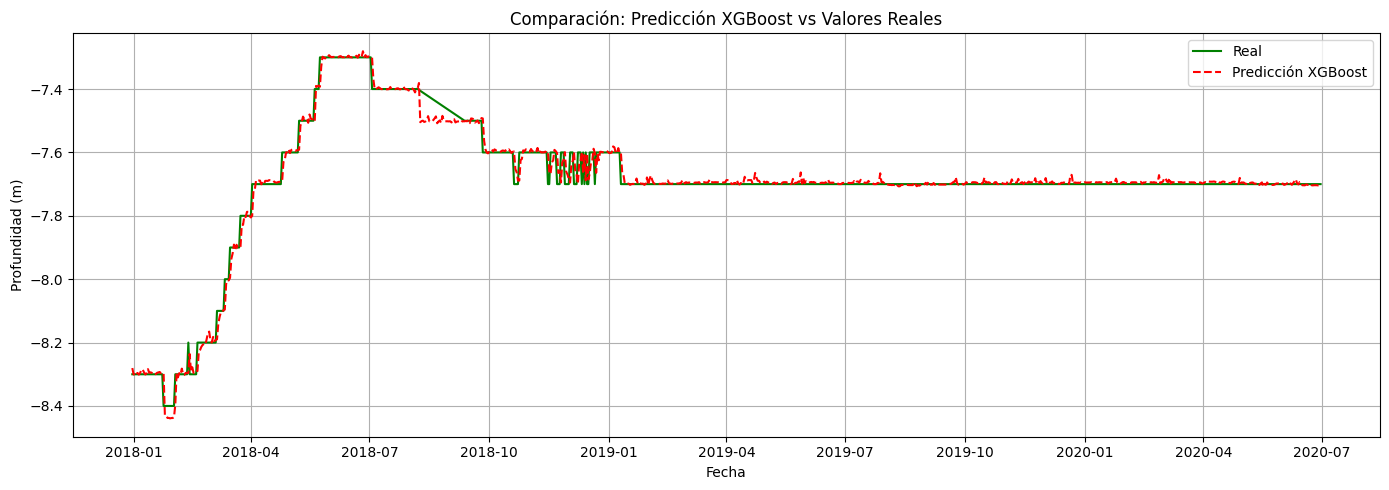

In [15]:
import matplotlib.pyplot as plt

# Crear gr√°fico comparativo
plt.figure(figsize=(14, 5))
plt.plot(y_test.index, y_test, label='Real', color='green')
plt.plot(y_test.index, y_pred, label='Predicci√≥n XGBoost', color='red', linestyle='--')
plt.title('Comparaci√≥n: Predicci√≥n XGBoost vs Valores Reales')
plt.xlabel('Fecha')
plt.ylabel('Profundidad (m)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## An√°lisis del Aplanamiento en la Gr√°fica de Predicci√≥n

### ¬øPor qu√© se aplana la predicci√≥n (y la serie real)?

Durante la visualizaci√≥n de la predicci√≥n vs valores reales, se observ√≥ un aplanamiento tanto en la serie real como en la predicci√≥n del modelo a partir de 2019.

### Posibles causas:

1. **Estabilizaci√≥n real del acu√≠fero**
   - La l√≠nea verde (datos reales) tambi√©n muestra una fase de estabilidad.
   - Puede deberse a un equilibrio entre recarga (lluvias) y extracci√≥n (volumen de pozos), o a menor actividad en el acu√≠fero.

2. **Aprendizaje del patr√≥n por parte del modelo**
   - XGBoost replica muy bien lo que aprende. Si detecta que el target es estable en funci√≥n de las variables clim√°ticas, lo predice con alta precisi√≥n.
   - El modelo no "fabrica" variabilidad que no existe en los datos.

3. **Poca variaci√≥n en los datos ex√≥genos**
   - Es posible que las variables como `Rainfall`, `Volume` y `Temperature` tambi√©n se hayan estabilizado, reforzando la predicci√≥n plana.
   - Esto puede verificarse visualmente en un an√°lisis adicional.

### Conclusi√≥n:

El aplanamiento observado es coherente con el comportamiento de la serie y el modelo. No representa un fallo, sino que refleja la din√°mica real aprendida por XGBoost.


## Importancia de Variables (Feature Importance)

A continuaci√≥n se presenta la importancia relativa de las variables utilizadas por el modelo **XGBoost**.

Esta visualizaci√≥n nos permite:

- Identificar qu√© variables tienen mayor peso en la predicci√≥n.
- Evaluar si la predicci√≥n depende m√°s del clima, volumen o de los valores pasados (lags).
- Priorizar variables relevantes para futuros modelos o estudios operativos.

La importancia se mide como el n√∫mero de veces que una variable fue utilizada para dividir nodos en los √°rboles del modelo.


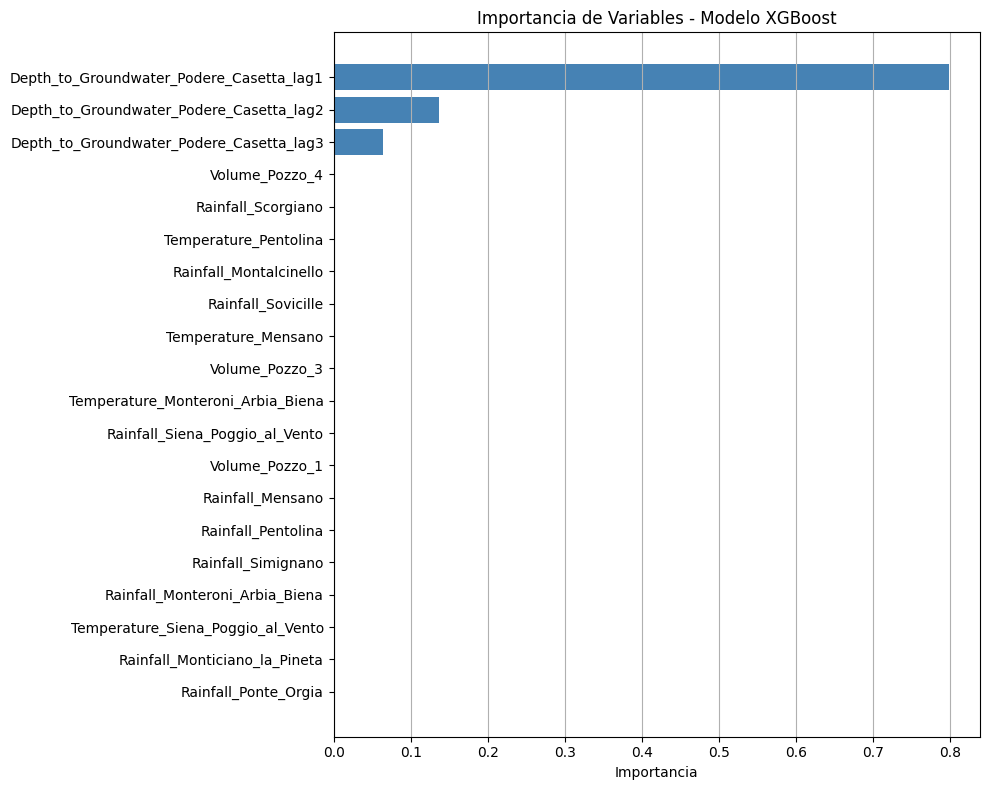

In [16]:
import matplotlib.pyplot as plt
import pandas as pd

# Obtener importancias
importancias = modelo_xgb.feature_importances_
features = X.columns

# Crear DataFrame ordenado
importancia_df = pd.DataFrame({
    'Feature': features,
    'Importancia': importancias
}).sort_values(by='Importancia', ascending=True)

# Gr√°fico horizontal
plt.figure(figsize=(10, 8))
plt.barh(importancia_df['Feature'], importancia_df['Importancia'], color='steelblue')
plt.title('Importancia de Variables - Modelo XGBoost')
plt.xlabel('Importancia')
plt.tight_layout()
plt.grid(True, axis='x')
plt.show()


## Cierre del Modelo Supervisado - XGBoost

Tras un proceso detallado de limpieza, transformaci√≥n y an√°lisis de la serie temporal correspondiente al acu√≠fero **Luco**, se concluy√≥ con √©xito el desarrollo de un modelo predictivo multivariable basado en **XGBoost**.

### Detalles t√©cnicos:

- **Target:** `Depth_to_Groundwater_Podere_Casetta`
- **Features:** Lluvia, temperatura, volumen de extracci√≥n y lags del target (`t-1`, `t-2`, `t-3`)
- **Modelo:** `XGBRegressor` con `n_estimators=100`, `max_depth=3`, `learning_rate=0.1`

###  Desempe√±o del modelo:

| M√©trica | Valor     |
|---------|-----------|
| MAE     | 0.0115    |
| RMSE    | 0.0234    |

El modelo mostr√≥ una alt√≠sima capacidad de ajuste, superando por amplio margen al modelo ARIMA base. La predicci√≥n replic√≥ fielmente la forma y din√°mica de la serie real, sin presentar desviaciones significativas.

### Conclusiones:

- Los **lags del target** fueron las variables m√°s importantes, confirmando un comportamiento autoregresivo dominante.
- La **lluvia y temperatura** no mostraron gran importancia en esta configuraci√≥n, posiblemente por no haber sido modeladas con retardo (lags ex√≥genos).
- El modelo est√° listo para ser utilizado en producci√≥n o servir como base para modelos m√°s complejos.


In [ ]:
import joblib

# Guardar el modelo entrenado
joblib.dump(modelo_xgb, 'modelo_xgboost_luco.pkl')
print("Modelo guardado como 'modelo_xgboost_luco.pkl'")


‚úÖ Modelo guardado como 'modelo_xgboost_luco.pkl'
